# COURSE: A deep understanding of deep learning
## SECTION: Metaparameters (activations, optimizers)
### LECTURE: Learning rate decay
#### TEACHER: Mike X Cohen, sincxpress.com
##### COURSE URL: udemy.com/course/deeplearning_x/?couponCode=202305

In [2]:
# import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

import numpy as np

import matplotlib.pyplot as plt
from IPython import display

display.set_matplotlib_formats('svg')

/tmp/ipykernel_5380/177268815.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  display.set_matplotlib_formats('svg')


# The data

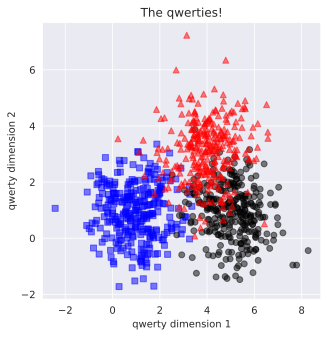

In [3]:
# create data

nPerClust = 300
blur = 1

A = [1, 1]
B = [5, 1]
C = [4, 3]

# generate data
a = [A[0] + np.random.randn(nPerClust) * blur, A[1] + np.random.randn(nPerClust) * blur]
b = [B[0] + np.random.randn(nPerClust) * blur, B[1] + np.random.randn(nPerClust) * blur]
c = [C[0] + np.random.randn(nPerClust) * blur, C[1] + np.random.randn(nPerClust) * blur]

# true labels
labels_np = np.hstack((np.zeros((nPerClust)),
                       np.ones((nPerClust)),
                       1 + np.ones((nPerClust))))

# concatanate into a matrix
data_np = np.hstack((a, b, c)).T

# convert to a pytorch tensor
data = torch.tensor(data_np).float()
labels = torch.tensor(labels_np).long()  # note: "long" format for CCE

# show the data
fig = plt.figure(figsize=(5, 5))
plt.plot(data[np.where(labels == 0)[0], 0], data[np.where(labels == 0)[0], 1], 'bs', alpha=.5)
plt.plot(data[np.where(labels == 1)[0], 0], data[np.where(labels == 1)[0], 1], 'ko', alpha=.5)
plt.plot(data[np.where(labels == 2)[0], 0], data[np.where(labels == 2)[0], 1], 'r^', alpha=.5)
plt.title('The qwerties!')
plt.xlabel('qwerty dimension 1')
plt.ylabel('qwerty dimension 2')
plt.show()

In [4]:
# use scikitlearn to split the data
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=.1)

# then convert them into PyTorch Datasets (note: already converted to tensors)
train_data = TensorDataset(train_data, train_labels)
test_data = TensorDataset(test_data, test_labels)

# finally, translate into dataloader objects
batchsize = 16
train_loader = DataLoader(train_data, batch_size=batchsize, shuffle=True, drop_last=True)
test_loader = DataLoader(test_data, batch_size=test_data.tensors[0].shape[0])

# The model

In [5]:
# create a class for the model
def createTheQwertyNet(initialLR):
    class qwertyNet(nn.Module):
        def __init__(self):
            super().__init__()

            ### input layer
            self.input = nn.Linear(2, 8)

            ### hidden layer
            self.fc1 = nn.Linear(8, 8)

            ### output layer
            self.output = nn.Linear(8, 3)

        # forward pass
        def forward(self, x):
            x = F.relu(self.input(x))
            x = F.relu(self.fc1(x))
            return self.output(x)

    # create the model instance
    net = qwertyNet()

    # loss function
    lossfun = nn.CrossEntropyLoss()

    # optimizer and LR scheduler
    optimizer = torch.optim.SGD(net.parameters(), lr=initialLR)
    stepsize = batchsize * len(train_loader)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=stepsize, gamma=.5)

    return net, lossfun, optimizer, scheduler

In [6]:
# how many steps until the learning rate changes?
len(train_loader) * batchsize, len(train_loader), batchsize

(800, 50, 16)

# Explore the learning rate decay parameter

In [7]:
# create a network
net = createTheQwertyNet(.01)[0]

# a new optimizer
optimizer = torch.optim.SGD(net.parameters(), lr=.01)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=1 / 2)

# test the change in learning rate
for epoch in range(3):
    for batchnum in range(10):
        print(f'Batch {batchnum}, epoch {epoch}: LR={scheduler.get_last_lr()[0]}')
        scheduler.step()

Batch 0, epoch 0: LR=0.01
Batch 1, epoch 0: LR=0.01
Batch 2, epoch 0: LR=0.01
Batch 3, epoch 0: LR=0.01
Batch 4, epoch 0: LR=0.01
Batch 5, epoch 0: LR=0.005
Batch 6, epoch 0: LR=0.005
Batch 7, epoch 0: LR=0.005
Batch 8, epoch 0: LR=0.005
Batch 9, epoch 0: LR=0.005
Batch 0, epoch 1: LR=0.0025
Batch 1, epoch 1: LR=0.0025
Batch 2, epoch 1: LR=0.0025
Batch 3, epoch 1: LR=0.0025
Batch 4, epoch 1: LR=0.0025
Batch 5, epoch 1: LR=0.00125
Batch 6, epoch 1: LR=0.00125
Batch 7, epoch 1: LR=0.00125
Batch 8, epoch 1: LR=0.00125
Batch 9, epoch 1: LR=0.00125
Batch 0, epoch 2: LR=0.000625
Batch 1, epoch 2: LR=0.000625
Batch 2, epoch 2: LR=0.000625
Batch 3, epoch 2: LR=0.000625
Batch 4, epoch 2: LR=0.000625
Batch 5, epoch 2: LR=0.0003125
Batch 6, epoch 2: LR=0.0003125
Batch 7, epoch 2: LR=0.0003125
Batch 8, epoch 2: LR=0.0003125
Batch 9, epoch 2: LR=0.0003125


/home/patryk/miniconda3/envs/pytorch/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


# Training

In [8]:
# a function that trains the model

def function2trainTheModel(initialLR, toggleDynamicLR):
    # number of epochs
    numepochs = 50

    # create a new model
    net, lossfun, optimizer, scheduler = createTheQwertyNet(initialLR)

    # initialize losses
    losses = torch.zeros(numepochs)
    trainAcc = []
    testAcc = []
    currentLR = []

    # loop over epochs
    for epochi in range(numepochs):

        # switch on training mode
        net.train()

        # loop over training data batches
        batchAcc = []
        batchLoss = []
        for X, y in train_loader:

            # forward pass and loss
            yHat = net(X)
            loss = lossfun(yHat, y)

            # backprop
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # step the learning-rate scheduler
            if toggleDynamicLR:
                scheduler.step()

            # loss from this batch
            batchLoss.append(loss.item())

            # compute accuracy
            matches = torch.argmax(yHat, axis=1) == y  # booleans (false/true)
            matchesNumeric = matches.float()  # convert to numbers (0/1)
            accuracyPct = 100 * torch.mean(matchesNumeric)  # average and x100 
            batchAcc.append(accuracyPct)  # add to list of accuracies

            currentLR.append(scheduler.get_last_lr()[0])
        # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        trainAcc.append(np.mean(batchAcc))

        # and get average losses across the batches
        losses[epochi] = np.mean(batchLoss)

        # test accuracy
        net.eval()
        X, y = next(iter(test_loader))  # extract X,y from test dataloader
        with torch.no_grad():  # deactivates autograd
            yHat = net(X)

        # compare the following really long line of code to the training accuracy lines
        testAcc.append(100 * torch.mean((torch.argmax(yHat, axis=1) == y).float()))

    # end epochs

    # function output
    return trainAcc, testAcc, losses, net, currentLR


# Test that the model really changes (sanity checks)

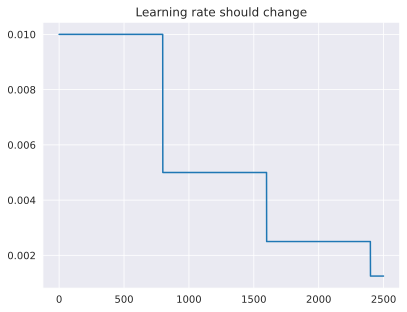

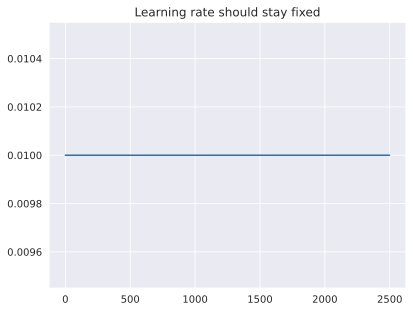

In [9]:
# test that the learning rate is really working
trainAcc, testAcc, losses, net, currentLR = function2trainTheModel(.01, True)
plt.plot(currentLR)
plt.title('Learning rate should change')
plt.show()

trainAcc, testAcc, losses, net, currentLR = function2trainTheModel(.01, False)
plt.plot(currentLR)
plt.title('Learning rate should stay fixed')
plt.show()

# Now for the experiment!

In [ ]:
# now test with and without dynamic LR
trainAccDynamic, testAccDynamic, losses, net, currentLR = function2trainTheModel(.01, True)
trainAccStatic, testAccStatic, losses, net, currentLR = function2trainTheModel(.01, False)

fig = plt.figure(figsize=(8, 5))
plt.plot(trainAccDynamic, 'r', label='Dyn: Train')
plt.plot(testAccDynamic, 'r--', label='Dyn: Test')

plt.plot(trainAccStatic, 'b', label='Stat: Train')
plt.plot(testAccStatic, 'b--', label='Stat: Test')

plt.xlabel('Training epochs')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy over epochs')
plt.legend()
plt.show()

# Additional explorations

In [ ]:
# 1) When you run the experiment in the previous cell multiple times, you can get different answers. This indicates
#    that the network and/or training regimen is not stable enough. What can you do to increase the stability of the
#    model and training? That is, what can you change to make the results more similar each time you re-run the experiment?
# 
# 2) There are several more options for dynamic learning rates in Pytorch. Try modifying the code!
#       See https://pytorch.org/docs/stable/optim.html
# 